# Prepare matplotlib

In [1]:
import json
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch
from matplotlib.ticker import MultipleLocator, NullFormatter

rc_fonts = {
    "text.usetex": True,
    "text.latex.preamble": "\n".join(
        [r"\usepackage{libertine}", r"\usepackage[libertine]{newtxmath}", r"\usepackage{inconsolata}"]
    ),
}
mpl.rcParams.update(rc_fonts)

# Load data

In [2]:
TICK_LABEL_SIZE = 14
AXIS_LABEL_SIZE = 16

In [3]:
# Functions for loading BLiMP data


def load_blimp_data(path: Path) -> dict:
    with path.open() as f:
        data = json.load(f)
    if "blimp" in data:
        data = data["blimp"]
    return data


def get_uids(data: dict):
    return np.array(list(data["by_uid"].values()))

In [4]:
# Load all BLiMP data
uid_scale = []
for scale in ("tiny", "small"):
    uid_data = []
    steps = list(range(0, 20_001, 1_000))
    for i in steps:
        baseline_data = load_blimp_data(Path(f"blimp_results_{scale}/step_{i}.json"))
        base_uids = get_uids(baseline_data)

        relora_data = load_blimp_data(Path(f"relora-{scale}-eval/step_{i}.json"))
        relora_uids = get_uids(relora_data)

        step_data = np.column_stack([base_uids, relora_uids])
        uid_data.append(step_data)

    uid_scale.append(np.column_stack(uid_data))

In [5]:
uid_data = uid_scale[0]
base = np.mean(uid_data[:, -2])
relora = np.mean(uid_data[:, -1])

print(np.mean(uid_data[:, -2] - uid_data[:, -1]))  # small = 0.07, tiny = 0.026

(base - relora) / base * 100

# tiny: 4.11%

# small: 10.07%


small = load_blimp_data(Path("relora-small-eval/step_20000.json"))
small_uids = get_uids(small)
tiny = load_blimp_data(Path("relora-tiny-eval/step_20000.json"))
tiny_uids = get_uids(tiny)
print("RELORA", np.mean((small_uids - tiny_uids) / tiny_uids))

small = load_blimp_data(Path("blimp_results_small/step_20000.json"))
small_uids = get_uids(small)
tiny = load_blimp_data(Path("blimp_results_tiny/step_20000.json"))
tiny_uids = get_uids(tiny)
print("BASE", np.mean((small_uids - tiny_uids) / tiny_uids))

0.0267462677030421
RELORA 0.06037209127099493
BASE 0.10876636338754972


/var/folders/2y/6ry1xqnj2r9_fpqf_pp017mw0000gn/T/ipykernel_42730/175528267.py:109: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


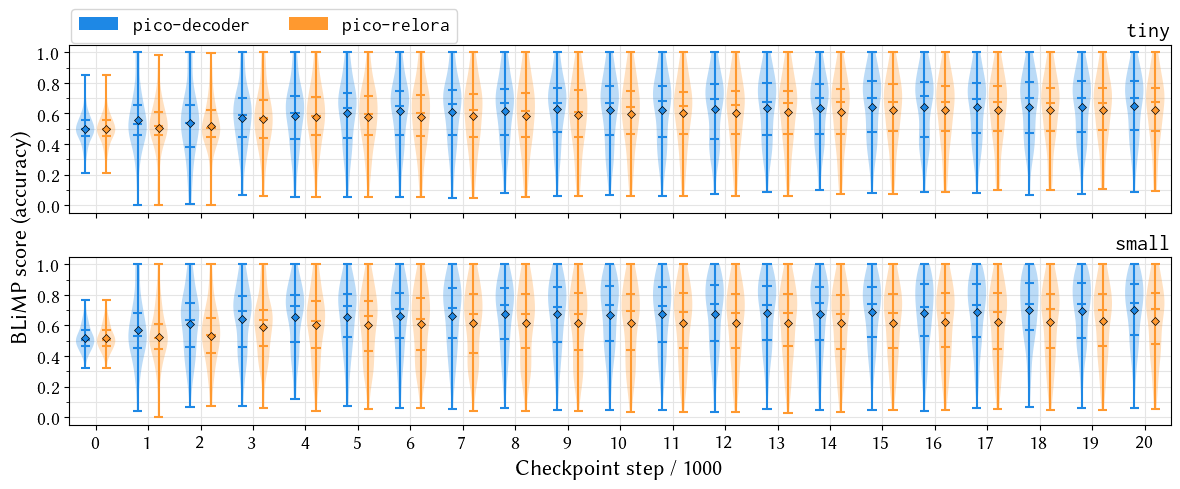

In [9]:
fig, axs = plt.subplots(2, 1, figsize=(12, 5), sharex=True)

labels = [r"\texttt{pico-decoder}", r"\texttt{pico-relora}"]
titles = [r"\texttt{tiny}", r"\texttt{small}"]

steps = np.arange(0, 21, 1) * 2
group_width = 0.9
violin_width = 0.7
offset = 0.05
real_offset = (violin_width / 2) + offset

positions = []
for i in steps:
    positions.extend([i - real_offset, i + real_offset])

LINE_WEIGHT = 0.75
colors = ["#1E88E5", "#FF992F"]

for ax_idx, (uid_data, ax) in enumerate(zip(uid_scale, axs)):
    vp = ax.violinplot(
        uid_data,
        positions=positions,
        widths=violin_width,
        showmeans=False,
        showmedians=True,
        showextrema=True,
        quantiles=[(0.25, 0.75) for _ in positions],
    )

    colors = ["#1E88E5", "#FF992F"]

    for idx, body in enumerate(vp["bodies"]):
        color = colors[idx % 2]
        body.set_facecolor(color)
        body.set_alpha(0.3)

    line_cols = [colors[idx % 2] for idx in range(len(positions))]
    for key in ("cmins", "cmaxes", "cbars", "cmedians"):
        vp[key].set_color(line_cols)

    line_cols_for_qs = [col for idx in range(len(positions)) for col in (colors[idx % 2], colors[idx % 2])]
    vp["cquantiles"].set_color(line_cols_for_qs)

    # Create violins
    for idx, (pos, ts) in enumerate(zip(positions, uid_data.T)):
        # Add mean marker
        ax.plot(
            pos,
            np.mean(ts),
            marker="D",
            markersize=4,
            markerfacecolor=colors[idx % 2],
            markeredgecolor="black",
            markeredgewidth=0.5,
            zorder=3,
            linestyle="None",
        )

    # Axes settings

    ax.set_xlim(-1, 41)

    ax.set_xticks(steps, labels=[str(i) for i in range(21)])

    if ax_idx == 1:
        ax.set_xlabel(r"Checkpoint step / 1000", fontdict=dict(fontsize=AXIS_LABEL_SIZE))

    ax.set_title(
        titles[ax_idx],
        loc="right",
        # backgroundcolor="#CCCCCC",
        # pad=10,
        fontsize=AXIS_LABEL_SIZE,
    )

    ax.tick_params(axis="both", labelsize=TICK_LABEL_SIZE)

    ax.yaxis.set_major_locator(MultipleLocator(0.2))
    ax.yaxis.set_minor_locator(MultipleLocator(0.1))
    ax.yaxis.set_minor_formatter(NullFormatter())
    ax.grid(which="both", axis="both", color="#E5E5E5")
    ax.set_axisbelow(True)

    if ax_idx == 0:
        # Add legend
        legend_elements = [Patch(facecolor=color, label=label) for color, label in zip(colors, labels)]
        ax.legend(
            handles=legend_elements,
            loc="lower left",
            bbox_to_anchor=(0, 1),
            borderaxespad=0.1,
            fontsize=TICK_LABEL_SIZE,
            ncol=len(legend_elements),
        )


fig.supylabel("PLACEHOLDER", fontsize=AXIS_LABEL_SIZE)

fig.tight_layout()

pos = [ax.get_position() for ax in axs]

leg_x = pos[0].x0 - 0.005
leg_y = (pos[0].y0 + pos[1].y1) / 2

fig.supylabel("BLiMP score (accuracy)", fontsize=AXIS_LABEL_SIZE, y=leg_y)

fig.savefig("../graphs/blimp_violin.pdf")
fig.show()